In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2023-08-16 14:12:20.082119: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-16 14:12:20.164780: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-16 14:12:20.166039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 14:12:22.753376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 11

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 11)                121       
                                                                 
Total params: 1191 (4.65 KB)
Trainable params: 1191 (4.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
13/22 [================>.............] - ETA: 0s - loss: 2.4421 - accuracy: 0.0745 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
22/22 [==============================] - 3s 30ms/step - loss: 2.4157 - accuracy: 0.0935 - val_loss: 2.3184 - val_accuracy: 0.1769
Epoch 2/1000
 8/22 [=========>....................] - ETA: 0s - loss: 2.3149 - accuracy: 0.1973

/home/mphstar/Development/Kiosk/Server/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/22 [======================>.......] - ETA: 0s - loss: 2.2957 - accuracy: 0.2160
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
22/22 [==============================] - 0s 15ms/step - loss: 2.2813 - accuracy: 0.2318 - val_loss: 2.1902 - val_accuracy: 0.4071
Epoch 3/1000
19/22 [========================>.....] - ETA: 0s - loss: 2.1881 - accuracy: 0.3479
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
22/22 [==============================] - 0s 14ms/step - loss: 2.1827 - accuracy: 0.3524 - val_loss: 2.0752 - val_accuracy: 0.4416
Epoch 4/1000
21/22 [===========================>..] - ETA: 0s - loss: 2.1011 - accuracy: 0.3891
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
22/22 [==============================] - 0s 11ms/step - loss: 2.1005 - accuracy: 0.3895 - val_loss: 1.9816 - val_accuracy: 0.4416
Epoch 5/1000
14/22 [==================>...........] - ETA: 0s - loss: 2.0595 - accuracy: 0.4040
Epoch 5: sa

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

8/8 [==============================] - 0s 5ms/step - loss: 0.4761 - accuracy: 0.9232


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 144ms/step
[9.9992037e-01 1.1520445e-13 3.1583995e-14 5.9392408e-17 7.8931167e-11
 6.1852195e-05 1.7808234e-05 4.3829572e-13 8.9220871e-16 3.2823345e-12
 1.8360786e-15]
0


# Confusion matrix

29/29 [==============================] - 0s 3ms/step


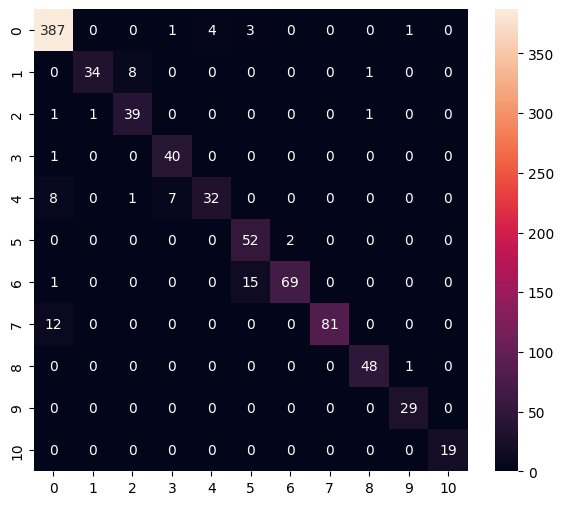

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       396
           1       0.97      0.79      0.87        43
           2       0.81      0.93      0.87        42
           3       0.83      0.98      0.90        41
           4       0.89      0.67      0.76        48
           5       0.74      0.96      0.84        54
           6       0.97      0.81      0.88        85
           7       1.00      0.87      0.93        93
           8       0.96      0.98      0.97        49
           9       0.94      1.00      0.97        29
          10       1.00      1.00      1.00        19

    accuracy                           0.92       899
   macro avg       0.91      0.91      0.90       899
weighted avg       0.93      0.92      0.92       899



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

/home/mphstar/Development/Kiosk/Server/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpkw5468rm/assets


INFO:tensorflow:Assets written to: /tmp/tmpkw5468rm/assets
2023-08-16 14:13:44.598166: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-16 14:13:44.598240: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-16 14:13:44.599393: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkw5468rm
2023-08-16 14:13:44.601065: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-08-16 14:13:44.601091: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpkw5468rm
2023-08-16 14:13:44.604791: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-08-16 14:13:44.608587: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-08-16 14:13:44.730550: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

6852

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 134 µs, sys: 9 µs, total: 143 µs
Wall time: 153 µs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.9992037e-01 1.1520467e-13 3.1584175e-14 5.9392633e-17 7.8931320e-11
 6.1852195e-05 1.7808230e-05 4.3829572e-13 8.9220871e-16 3.2823343e-12
 1.8360856e-15]
0
